In [1]:
%matplotlib inline

https://raw.githubusercontent.com/jhoward/Python-Neural-Network/master/nn.py

Code is placed in public domain.

In [2]:
import math
import random
import numpy as np

In [3]:
def rand(a, b):
    """ Calculate a random number where:  a <= rand < b """
    return (b - a) * random.random() + a


def makeMatrix(I, J, fill=0.0):
    """ Make a matrix (we could use NumPy to speed this up) """
    m = []
    for i in range(I):
        m.append([fill]*J)
    return m


def sigmoid(x):
    """ Our sigmoid function, tanh is a little nicer than
        the standard 1/(1+e^-x) """
    return math.tanh(x)


def dsigmoid(y):
    """ Derivative of our sigmoid function,
        in terms of the output (i.e. y) """
    return 1.0 - y**2


def plot(inputs, outputs, actual):
    """
    Plot a given function.

    The actual function will be plotted with a line and the outputs with
    points.  Useful for visualizing the error of the neural networks attempt
    at function interpolation.
    """
    try:
        import matplotlib.pyplot as pl
    except:
        raise ImportError("matplotlib package not found.")

    pl.xkcd()
    pl.title('function Formula')
    pl.xlabel('x')
    pl.ylabel('y')
    pl.plot(inputs, actual, 'b-')
    pl.plot(inputs, outputs, 'r.')
    pl.show()


def plot_ess(err):
    """ """
    try:
        import matplotlib.pyplot as pl
    except:
        raise ImportError("matplotlib package not found.")

    pl.xkcd()
    pl.title('Train network (newff)')
    pl.xlabel('Epoch number')
    pl.ylabel('error (default SSE)')
    # add min value to plot
    x = np.linspace(0, len(err), len(err))
    pl.plot(x, err)
    ymin, ymax = pl.ylim()
    pl.ylim(ymin-1, ymax)
    pl.show()

In [4]:
class NN:
    def __init__(self, ni, nh, no, regression=False):
        """NN constructor.

        ni, nh, no are the number of input, hidden and output nodes.
        regression is used to determine if the Neural network will be trained
        and used as a classifier or for function regression.
        """

        self.regression = regression

        # Number of input, hidden and output nodes.
        self.ni = ni + 1  # +1 for bias node
        self.nh = nh + 1  # +1 for bias node
        self.no = no

        # activations for nodes
        self.ai = [1.0]*self.ni
        self.ah = [1.0]*self.nh
        self.ao = [1.0]*self.no

        # create weights
        self.wi = makeMatrix(self.ni, self.nh)
        self.wo = makeMatrix(self.nh, self.no)

        # set them to random vaules
        for i in range(self.ni):
            for j in range(self.nh):
                self.wi[i][j] = rand(-1, 1)
        for j in range(self.nh):
            for k in range(self.no):
                self.wo[j][k] = rand(-1, 1)

        # last change in weights for momentum
        self.ci = makeMatrix(self.ni, self.nh)
        self.co = makeMatrix(self.nh, self.no)

    def update(self, inputs):
        if len(inputs) != self.ni-1:
            raise ValueError('wrong number of inputs')

        # input activations
        for i in range(self.ni - 1):
            self.ai[i] = inputs[i]

        # hidden activations
        for j in range(self.nh - 1):
            total = 0.0
            for i in range(self.ni):
                total += self.ai[i] * self.wi[i][j]
            self.ah[j] = sigmoid(total)

        # output activations
        for k in range(self.no):
            total = 0.0
            for j in range(self.nh):
                total += self.ah[j] * self.wo[j][k]
            self.ao[k] = total
            if not self.regression:
                self.ao[k] = sigmoid(total)

        return self.ao[:]

    def backPropagate(self, targets, N, M):
        if len(targets) != self.no:
            raise ValueError('wrong number of target values')

        # calculate error terms for output
        output_deltas = [0.0] * self.no
        for k in range(self.no):
            output_deltas[k] = targets[k] - self.ao[k]
            if not self.regression:
                output_deltas[k] = dsigmoid(self.ao[k]) * output_deltas[k]

        # calculate error terms for hidden
        hidden_deltas = [0.0] * self.nh
        for j in range(self.nh):
            error = 0.0
            for k in range(self.no):
                error += output_deltas[k]*self.wo[j][k]
            hidden_deltas[j] = dsigmoid(self.ah[j]) * error

        # update output weights
        for j in range(self.nh):
            for k in range(self.no):
                change = output_deltas[k]*self.ah[j]
                self.wo[j][k] = self.wo[j][k] + N*change + M*self.co[j][k]
                self.co[j][k] = change

        # update input weights
        for i in range(self.ni):
            for j in range(self.nh):
                change = hidden_deltas[j]*self.ai[i]
                self.wi[i][j] = self.wi[i][j] + N*change + M*self.ci[i][j]
                self.ci[i][j] = change

        # calculate error
        error = 0.0
        for k in range(len(targets)):
            error += 0.5*((targets[k]-self.ao[k])**2)
        return error

    def test(self, patterns, verbose=False):
        tmp = []
        for p in patterns:
            if verbose:
                print p[0], '->', self.update(p[0])
            tmp.append(self.update(p[0]))

        return tmp

    def weights(self):
        print 'Input weights:'
        for i in range(self.ni):
            print self.wi[i]
        print
        print 'Output weights:'
        for j in range(self.nh):
            print self.wo[j]

    def train(self, patterns, iterations=1000, N=0.5, M=0.1, verbose=False):
        """Train the neural network.

        N is the learning rate.
        M is the momentum factor.
        """
        err = []
        for i in xrange(iterations):
            error = 0.0
            for p in patterns:
                self.update(p[0])
                tmp = self.backPropagate(p[1], N, M)
                error += tmp

            if verbose:
                if i % int(iterations / 10) == 0:
                    print 'iter= %i' % i, 'error %-14f' % error
            err.append(error)

        return err

In [5]:
def demoRegression():
    data = []
    inputs = []
    actual = []

    domain = [-8, 8]
    steps = 150
    stepsize = (domain[1] - domain[0]) / ((steps - 1)*1.0)

    # Teach the network the function y = x**2
    for i in range(steps):
        x = domain[0] + stepsize * i
        y = x**2
        y = math.sin(x)

        data.append([[x], [y]])
        inputs.append(x)
        actual.append(y)

    n = NN(1, 7, 1, regression=True)

    # Train and test the nural network.
    plot_ess(n.train(data, 5000, 0.002, 0.001, verbose=True))
    outputs = n.test(data, verbose=False)

    # Plot the function.
    try:
        plot(inputs, outputs, actual)
    except:
        print "Must have matplotlib to plot."

In [6]:
def demoClassification():
    # Teach network XOR function
    pat = [
        [[0, 0], [0]],
        [[0, 1], [1]],
        [[1, 0], [1]],
        [[1, 1], [0]]
    ]

    # create a network with two input, two hidden, and one output nodes
    n = NN(2, 2, 1, regression=False)

    # train it with some patterns then test it.
    n.train(pat, 1000, 0.5, 0.2)
    n.test(pat, verbose=True)

iter= 0 error 49.395849     
iter= 500 error 13.241089     
iter= 1000 error 0.162044      
iter= 1500 error 0.120980      
iter= 2000 error 0.100004      
iter= 2500 error 0.082724      
iter= 3000 error 0.072341      
iter= 3500 error 0.066766      
iter= 4000 error 0.063489      
iter= 4500 error 0.060996      


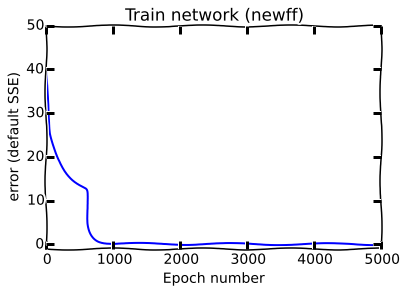

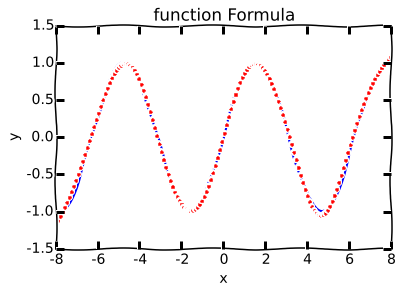

CPU times: user 1min, sys: 20 ms, total: 1min
Wall time: 1min 1s


In [11]:
random.seed()
%time demoRegression()

In [8]:
random.seed()
demoClassification()

[0, 0] -> [0.12712940140230167]
[0, 1] -> [0.9875468123643478]
[1, 0] -> [0.9875567894540054]
[1, 1] -> [-0.021845701404102122]
